# ВВЕДЕНИЕ

Условие задачи следующее:

***
*данные о целостности корпуса космического шаттла обеспечиваются семью установленными на нём детекторами, каждый из которых описывает состояние элементов обшивки в собственных измеряемых величинах. Некоторые элементы связаны между собой. Каждый детектор дополнительно снабжён сигнальными датчиками, срабатывающими в моменты непосредственной угрозы элементам обшивки: зелёный сигнал — когда всё в порядке, жёлтый — во время незначительных повреждений, красный — в критическом состоянии.*

*Данные показаний детекторов **(Detector A-G)** и соответствующих сигнальных датчиков **(Signal A-G)** в разные моменты времени указаны в таблице приложения.*

*Предложите функцию от показаний всех детекторов, которая описала бы общее состояние системы обшивки в процентах: **95%-100%** — когда все показания в норме (все сигналы зелёные), **60%-95%** — когда есть жёлтые и зелёные сигналы (чем больше зелёных, тем выше процент), **меньше 60%** — когда есть красные сигналы (три или более красных сигнала — **0%**).*

*Необходимо переформулировать задачу в терминах машинного обучения. Предложить гипотезы, на основе которых построить общий вид функции состояния обшивки. Найти неизвестные (выбор технического инструментария для данной задачи свободный). Оценить погрешности расчётов (предпочтительно), либо определить функционал качества предложенной модели.*

***

Соответственно имеем массив признаковых описаний объектов, где объект - состояние системы в момент времени t - описано 14 признаками, семь вещественных и семь категориальных. Из задачи известно, что каждый категориальный признак имеет три категории: зеленый, желтый и красный. Соответственно система в целом может находиться в состояниях, количество которых равно $$ N = 3^7 = 2187.$$ Каждое из этих состояний является упорядоченной последовательностью категорий, каждая может быть свернута в некоторое число (например, если закодировать каждую категорию числом а затем просуммировать все числа в последовательности). Пусть зеленый - это 3, желтый - 1, красный - -4. Тогда состояние из всех зеленых сигналов даст 21, состояние из тех красных и оставшихся зеленых - 0, состояние из 2 зеленых, 4 желтых и одного ркасного - 6 и так далее. Таким образом можно выразить общее состояние системы в данных случаях, как: $$\frac{21}{21}\cdot100 = 100\%; \ \frac{0}{21}\cdot100 = 0\%; \ \frac{6}{21}\cdot100 \approx 28.57\%.$$ Для каждого датчика его состояние необходимо определить по тому значению, которое было зафиксировано детектором в момент времени t. Соответственно общее состояние системы, как объект, можно разбить на семь объектом, для каждого из которых есть множество объектных описаний X, где объектное описание - это значение, зафиксированное на детекторе, множество допустимых ответов Y - сигналов, зафиксированных на датчике, и существует множество целевых функций: $$y_i^* : X \to Y, i = 1,...,7; \ значения \ известны \ на \ \{x_1, x_2, ..., x_l\} \subseteq X.$$ Таким образом необходимо для семи раных датчиков решить задачу класификации с тем, чтобы впоследствии каждое из значений на датчиках относить к определенному состоянию. Ошибку в такой постановке задачи можно будет определить как интегральную ошибку классификации.

# СОЗДАНИЕ DAFAFRAME И ЕГО ПЕРВИЧНОЕ ИССЛЕДОВАНИЕ

In [25]:
import pandas as pd
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

df = pd.read_excel("Приложение 1.xlsx")

df.head()

,Detector A,Signal A,Detector B,Signal B,Detector C,Signal C,Detector D,Signal D,Detector E,Signal E,Detector F,Signal F,Detector G,Signal G
0,37.6,green,37.7,green,74.5,yellow,52.1,green,60.1,yellow,50.1,green,32.6,yellow
1,27.5,green,36.3,green,81.6,green,76.2,green,75.6,green,49.5,green,43.4,green
2,34.3,yellow,31.2,red,78.3,yellow,38.6,yellow,51.2,red,37.8,red,27.6,red
3,5.5,yellow,17.1,yellow,62.0,yellow,51.5,green,61.0,green,44.8,yellow,28.9,green
4,7.2,green,19.7,green,68.1,yellow,57.8,green,71.2,green,49.8,green,38.8,green


In [23]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 14 columns):
Detector A    684 non-null float64
Signal A      684 non-null object
Detector B    684 non-null float64
Signal B      684 non-null object
Detector C    684 non-null float64
Signal C      684 non-null object
Detector D    684 non-null float64
Signal D      684 non-null object
Detector E    684 non-null float64
Signal E      684 non-null object
Detector F    684 non-null float64
Signal F      684 non-null object
Detector G    684 non-null float64
Signal G      684 non-null object
dtypes: float64(7), object(7)
memory usage: 74.9+ KB


In [24]:
df.describe()

,Detector A,Detector B,Detector C,Detector D,Detector E,Detector F,Detector G
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,25.742544,31.913596,69.247515,54.968421,62.666520,46.101170,35.179094
std,9.451732,7.004529,8.031994,10.965882,10.801909,5.934701,8.625797
min,1.100000,15.300000,48.300000,22.000000,29.600000,24.500000,6.700000
25%,20.100000,27.175000,63.875000,48.000000,56.000000,42.500000,30.375000
50%,26.800000,31.800000,69.600000,55.400000,62.300000,46.800000,35.700000
75%,32.500000,36.500000,74.700000,62.225000,69.925000,50.200000,41.000000
max,49.000000,57.200000,89.600000,85.800000,99.600000,61.200000,57.300000


# ИССЛЕДОВАНИЕ ВОЗМОЖНЫХ ЗАВИСИМОСТЕЙ

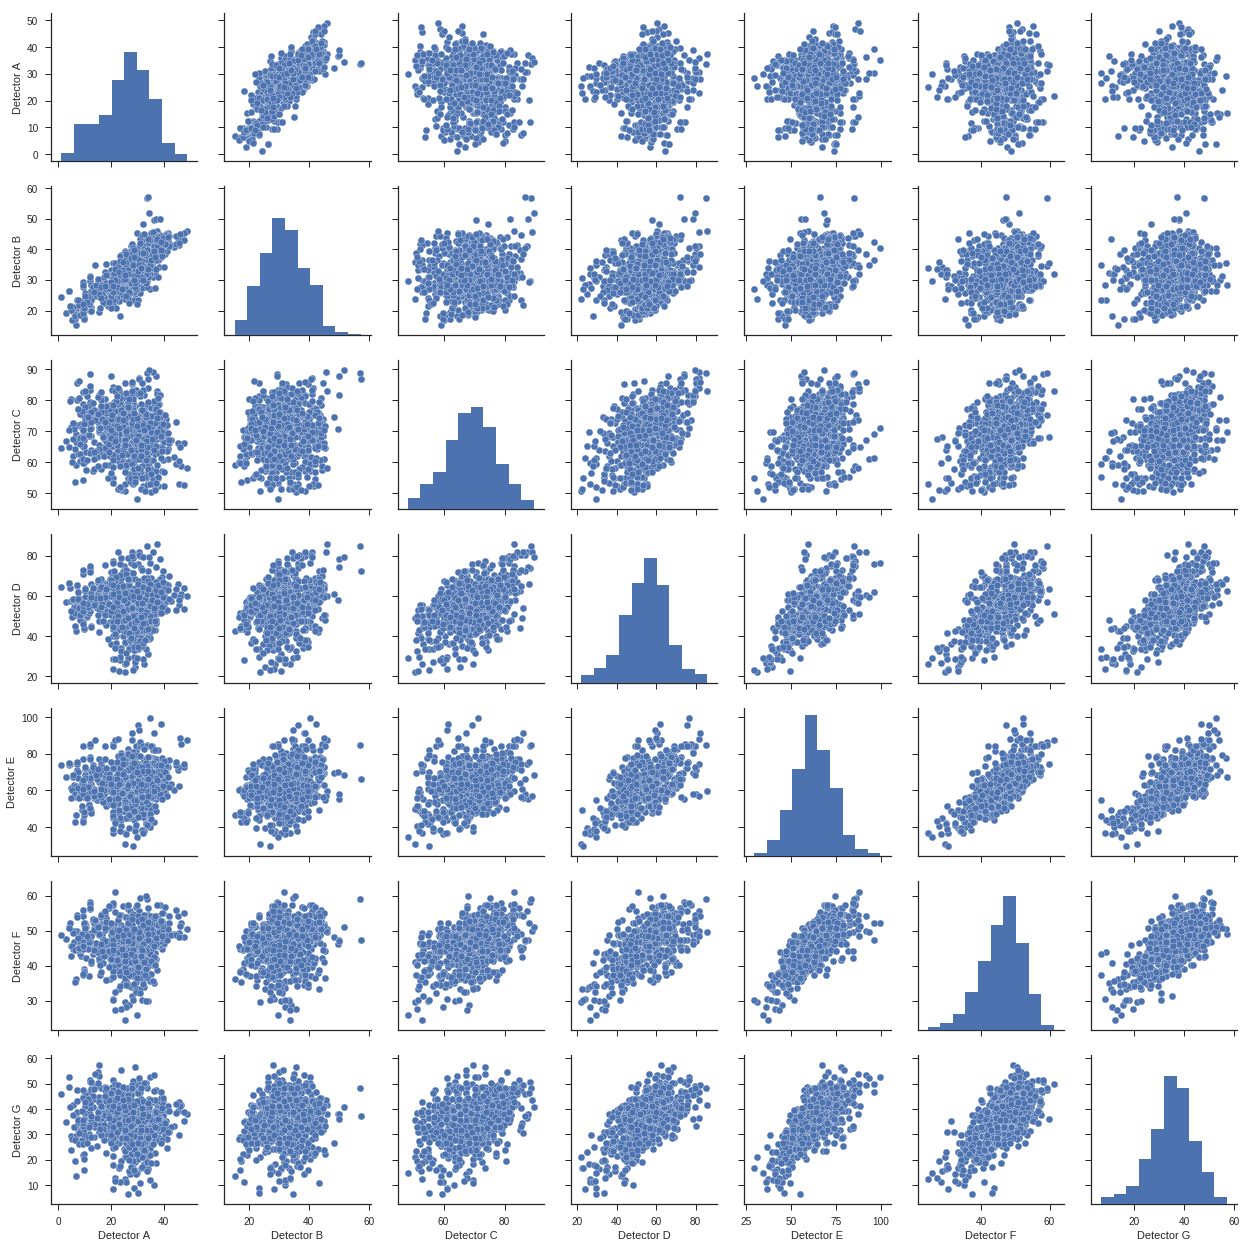

In [18]:
sns.set(style="ticks", color_codes=True)

sns.pairplot(df.loc[:, [
    "Detector A",
    "Detector B",
    "Detector C",
    "Detector D",
    "Detector E",
    "Detector F",
    "Detector G"
]])

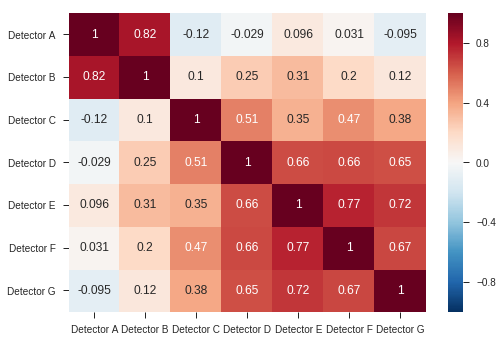

In [22]:
corr = df.corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# РАЗБИЕНИЕ ДАННЫХ ДЛЯ ПОСЛЕДУЮЩЕГО ОБУЧЕНИЯ И КОНТРОЛЯ

In [190]:
from sklearn import cross_validation

train_test_ratio = 0.1

A_DATA, A_TARGET = df.loc[:, ['Detector A']], df.loc[:, ['Signal A']]
B_DATA, B_TARGET = df.loc[:, ['Detector B']], df.loc[:, ['Signal B']]
C_DATA, C_TARGET = df.loc[:, ['Detector C']], df.loc[:, ['Signal C']]
D_DATA, D_TARGET = df.loc[:, ['Detector D']], df.loc[:, ['Signal D']]
E_DATA, E_TARGET = df.loc[:, ['Detector E']], df.loc[:, ['Signal E']]
F_DATA, F_TARGET = df.loc[:, ['Detector F']], df.loc[:, ['Signal F']]
G_DATA, G_TARGET = df.loc[:, ['Detector G']], df.loc[:, ['Signal G']]

A_TRAIN_DATA, A_TEST_DATA, A_TRAIN_TARGET, A_TEST_TARGET = cross_validation.train_test_split(
    A_DATA, A_TARGET,
    test_size = train_test_ratio
)
B_TRAIN_DATA, B_TEST_DATA, B_TRAIN_TARGET, B_TEST_TARGET = cross_validation.train_test_split(
    B_DATA, B_TARGET,
    test_size = train_test_ratio
)
C_TRAIN_DATA, C_TEST_DATA, C_TRAIN_TARGET, C_TEST_TARGET = cross_validation.train_test_split(
    C_DATA, C_TARGET,
    test_size = train_test_ratio
)
D_TRAIN_DATA, D_TEST_DATA, D_TRAIN_TARGET, D_TEST_TARGET = cross_validation.train_test_split(
    D_DATA, D_TARGET,
    test_size = train_test_ratio
)
E_TRAIN_DATA, E_TEST_DATA, E_TRAIN_TARGET, E_TEST_TARGET = cross_validation.train_test_split(
    E_DATA, E_TARGET,
    test_size = train_test_ratio
)
F_TRAIN_DATA, F_TEST_DATA, F_TRAIN_TARGET, F_TEST_TARGET = cross_validation.train_test_split(
    F_DATA, F_TARGET,
    test_size = train_test_ratio
)
G_TRAIN_DATA, G_TEST_DATA, G_TRAIN_TARGET, G_TEST_TARGET = cross_validation.train_test_split(
    G_DATA, G_TARGET,
    test_size = train_test_ratio
)



# СОЗДАНИЕ И ОБУЧЕНИЕ КЛАССИФИКАТОРОВ

In [273]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

A_CLASSIFIER = RadiusNeighborsClassifier(radius=4.0, p=3)
B_CLASSIFIER = RadiusNeighborsClassifier(radius=7.0, p=3)
C_CLASSIFIER = RadiusNeighborsClassifier(radius=5.0, p=3)
D_CLASSIFIER = RadiusNeighborsClassifier(radius=6.0, p=3)
E_CLASSIFIER = RadiusNeighborsClassifier(radius=2.0, p=3)
F_CLASSIFIER = RadiusNeighborsClassifier(radius=3.0, p=3)
G_CLASSIFIER = RadiusNeighborsClassifier(radius=2.0, p=3)

A_CLASSIFIER.fit(A_TRAIN_DATA, A_TRAIN_TARGET)
B_CLASSIFIER.fit(B_TRAIN_DATA, B_TRAIN_TARGET)
C_CLASSIFIER.fit(C_TRAIN_DATA, C_TRAIN_TARGET)
D_CLASSIFIER.fit(D_TRAIN_DATA, D_TRAIN_TARGET)
E_CLASSIFIER.fit(E_TRAIN_DATA, E_TRAIN_TARGET)
F_CLASSIFIER.fit(F_TRAIN_DATA, F_TRAIN_TARGET)
G_CLASSIFIER.fit(G_TRAIN_DATA, G_TRAIN_TARGET)

print accuracy_score(A_TEST_TARGET, A_CLASSIFIER.predict(A_TEST_DATA))
print accuracy_score(B_TEST_TARGET, B_CLASSIFIER.predict(B_TEST_DATA))
print accuracy_score(C_TEST_TARGET, C_CLASSIFIER.predict(C_TEST_DATA))
print accuracy_score(D_TEST_TARGET, D_CLASSIFIER.predict(D_TEST_DATA))
print accuracy_score(E_TEST_TARGET, E_CLASSIFIER.predict(E_TEST_DATA))
print accuracy_score(F_TEST_TARGET, F_CLASSIFIER.predict(F_TEST_DATA))
print accuracy_score(G_TEST_TARGET, G_CLASSIFIER.predict(G_TEST_DATA))
print '==============================================================='

state_codes = {'green':3, 'yellow':1, 'red':-4}

A_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  A_TEST_TARGET.values]
B_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  B_TEST_TARGET.values]
C_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  C_TEST_TARGET.values]
D_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  D_TEST_TARGET.values]
E_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  E_TEST_TARGET.values]
F_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  F_TEST_TARGET.values]
G_TEST_TARGET_CODES = [state_codes.get(state[0]) for state in  G_TEST_TARGET.values]


A_TEST_PRED_CODES = [state_codes.get(state) for state in  A_CLASSIFIER.predict(A_TEST_DATA)]
B_TEST_PRED_CODES = [state_codes.get(state) for state in  B_CLASSIFIER.predict(B_TEST_DATA)]
C_TEST_PRED_CODES = [state_codes.get(state) for state in  C_CLASSIFIER.predict(C_TEST_DATA)]
D_TEST_PRED_CODES = [state_codes.get(state) for state in  D_CLASSIFIER.predict(D_TEST_DATA)]
E_TEST_PRED_CODES = [state_codes.get(state) for state in  E_CLASSIFIER.predict(E_TEST_DATA)]
F_TEST_PRED_CODES = [state_codes.get(state) for state in  F_CLASSIFIER.predict(F_TEST_DATA)]
G_TEST_PRED_CODES = [state_codes.get(state) for state in  G_CLASSIFIER.predict(G_TEST_DATA)]


TARGET = np.stack((
    A_TEST_TARGET_CODES,
    B_TEST_TARGET_CODES,
    C_TEST_TARGET_CODES,
    D_TEST_TARGET_CODES,
    E_TEST_TARGET_CODES,
    F_TEST_TARGET_CODES,
    G_TEST_TARGET_CODES
))

PRED = np.stack((
    A_TEST_PRED_CODES,
    B_TEST_PRED_CODES,
    C_TEST_PRED_CODES,
    D_TEST_PRED_CODES,
    E_TEST_PRED_CODES,
    F_TEST_PRED_CODES,
    G_TEST_PRED_CODES
))
mean_percent_error = 0
for i in range(PRED.shape[1]):
    act = round(max(0, sum(TARGET[:, i])) / 21. * 100., 2)
    pred = round(max(0, sum(PRED[:, i])) / 21. * 100., 2)
    mean_percent_error = mean_percent_error + abs(act - pred)
    print 'Actual:', act, ', Predicted:', pred, ', Difference: ', act - pred
print '==============================================================='
print 'Mean: ', mean_percent_error / float(PRED.shape[1])

0.623188405797
0.449275362319
0.478260869565
0.521739130435
0.536231884058
0.550724637681
0.623188405797
Actual: 14.29 , Predicted: 4.76 , Difference:  9.53
Actual: 57.14 , Predicted: 57.14 , Difference:  0.0
Actual: 52.38 , Predicted: 52.38 , Difference:  0.0
Actual: 23.81 , Predicted: 47.62 , Difference:  -23.81
Actual: 23.81 , Predicted: 38.1 , Difference:  -14.29
Actual: 23.81 , Predicted: 28.57 , Difference:  -4.76
Actual: 4.76 , Predicted: 28.57 , Difference:  -23.81
Actual: 57.14 , Predicted: 14.29 , Difference:  42.85
Actual: 14.29 , Predicted: 71.43 , Difference:  -57.14
Actual: 80.95 , Predicted: 47.62 , Difference:  33.33
Actual: 19.05 , Predicted: 28.57 , Difference:  -9.52
Actual: 80.95 , Predicted: 90.48 , Difference:  -9.53
Actual: 38.1 , Predicted: 47.62 , Difference:  -9.52
Actual: 0.0 , Predicted: 38.1 , Difference:  -38.1
Actual: 47.62 , Predicted: 71.43 , Difference:  -23.81
Actual: 23.81 , Predicted: 38.1 , Difference:  -14.29
Actual: 47.62 , Predicted: 71.43 , Dif

/home/bender/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/bender/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/bender/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/bender/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/bender/anaconda2/lib/python2.7/site-packages/ipykernel/__main_